In [157]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Data Preprocessing + Data Analysis
This part is for data preprocessing and conduct a comprehensive analysis on the dataset by visualizing data's feature.

In [159]:
DATA_PATH = "../chatbot__fragrance_recommendation/data/noon_perfumes_dataset.csv"
data = pd.read_csv(DATA_PATH)
df_analyze = pd.DataFrame(data)

In [160]:
df_analyze.head()

,Unnamed: 0,brand,name,old_price,new_price,ml,concentration,department,scents,base_note,middle_note,item_rating,seller,seller_rating,num_seller_ratings
0,0,PACO RABANNE,1 Million Lucky,395.0,244.55,100,EDT,Men,Woody,"Oakmoss, Patchouli and Vetiver","Hazelnut, Jasmine, Cashmir Wood, Cedar and Honey",5.0,noon,4.2,98.1K
1,1,Roberto Cavalli,Paradiso Assoluto,415.0,107.95,50,EDP,Women,Floral,"Vanilla, Sandalwood And Patchouli",Wild Jasmine and Red Lily,4.8,noon,4.2,98.1K
2,2,S.T.Dupont,Royal Amber,265.0,186.90,100,EDP,Unisex,Arabian,"Lemon, Mint and Wood Moss",Sandalwood and Cedar,5.0,noon,4.2,98.1K
3,3,GUESS,Seductive Blue,290.0,103.20,100,EDT,Men,Spicy,"Cashmere Wood, Moss And Rippled Sand Accord",Blue Coral Aquaspace Accord And Geranium,3.0,noon,4.2,98.1K
4,4,Roberto Cavalli,Uomo,260.0,94.95,50,EDP,Women,Arabian,"Vanille, Benzoin, Tonka Bean",African Orange Flower,4.8,noon,4.2,98.1K


In [161]:
def fix_rating(r):
    if r > 5:
        if r < 100:
            r = r/10
        elif r > 100:
            r = r/100
    return r
        
df_analyze['seller_rating'] = df_analyze['seller_rating'].apply(fix_rating)

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_price_distribution(df_analyze, figsize=(14, 10)):
    # Plot price distribution analysis using seaborn with error handling

    df_analyze = df_analyze.copy()
    df_analyze['price_per_ml'] = df_analyze['new_price'] / df_analyze['ml']
 
    if 'price_per_ml' in df_analyze.columns:
        df_analyze = df_analyze.copy()
        df_analyze['price_per_100ml'] = df_analyze['price_per_ml'] * 100
        
        def map_budget_range(price_per_100ml):
            if price_per_100ml < 50:
                return '<50'
            elif 50 <= price_per_100ml < 100:
                return '50-100'
            elif 100 <= price_per_100ml < 150:
                return '100-150'
            elif 150 <= price_per_100ml < 200:
                return '150-200'
            elif 200 <= price_per_100ml < 300:
                return '200-300'
            else:
                return '300+'
        
        df_analyze['budget_range_label'] = df_analyze['price_per_100ml'].apply(map_budget_range)
    
    # Set seaborn style
    sns.set_style("whitegrid")
    plt.style.use('default')
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Price distribution using seaborn
    sns.histplot(data=df_analyze, x='new_price', bins=40, kde=True, ax=axes[0,0], color='skyblue', alpha=0.7)
    axes[0,0].set_title('Price Distribution', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Price ($)')
    axes[0,0].set_ylabel('Frequency')
    
    # Add statistics text
    mean_price = df_analyze['new_price'].mean()
    median_price = df_analyze['new_price'].median()
    axes[0,0].axvline(mean_price, color='red', linestyle='--', alpha=0.7, label=f'Mean: ${mean_price:.2f}')
    axes[0,0].axvline(median_price, color='orange', linestyle='--', alpha=0.7, label=f'Median: ${median_price:.2f}')
    axes[0,0].legend()
    
    # 2. Price per ML distribution using seaborn
    sns.histplot(data=df_analyze, x='price_per_ml', bins=40, kde=True, ax=axes[0,1], color='lightcoral', alpha=0.7)
    axes[0,1].set_title('Price per ml Distribution', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Price per ml ($)')
    axes[0,1].set_ylabel('Frequency')
    
    # Add statistics
    mean_pml = df_analyze['price_per_ml'].mean()
    median_pml = df_analyze['price_per_ml'].median()
    axes[0,1].axvline(mean_pml, color='red', linestyle='--', alpha=0.7, label=f'Mean: ${mean_pml:.2f}')
    axes[0,1].axvline(median_pml, color='orange', linestyle='--', alpha=0.7, label=f'Median: ${median_pml:.2f}')
    axes[0,1].legend()
    
    # 3. Budget range distribution using seaborn
    budget_order = ['<50', '50-100', '100-150', '150-200', '200-300', '300+']
    budget_data = df_analyze['budget_range_label'].value_counts()
    
    # Reorder according to budget_order if possible
    try:
        budget_data = budget_data.reindex([x for x in budget_order if x in budget_data.index])
    except:
        pass
    
    sns.barplot(x=budget_data.index, y=budget_data.values, ax=axes[1,0], palette='viridis', alpha=0.8)
    axes[1,0].set_title('Budget Range Distribution', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Budget Range ($ per 100ml)')
    axes[1,0].set_ylabel('Count')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for i, v in enumerate(budget_data.values):
        axes[1,0].text(i, v + max(budget_data.values)*0.01, str(v), 
                      ha='center', va='bottom', fontweight='bold')
    
    # 4. Price by Department using seaborn boxplot
    if 'department' in df_analyze.columns:
        sns.boxplot(data=df_analyze, x='department', y='new_price', ax=axes[1,1], palette='Set2')
        axes[1,1].set_title('Price Distribution by Department', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Department')
        axes[1,1].set_ylabel('Price ($)')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # Add mean points
        sns.stripplot(data=df_analyze, x='department', y='new_price', ax=axes[1,1], size=4, color='red', alpha=0.6)
    else:
        # Alternative: Price vs Volume scatter if department not available
        if 'ml' in df_analyze.columns:
            sns.scatterplot(data=df_analyze, x='ml', y='new_price', ax=axes[1,1], 
                           alpha=0.6, s=50)
            axes[1,1].set_title('Price vs Volume', fontsize=14, fontweight='bold')
            axes[1,1].set_xlabel('Volume (ML)')
            axes[1,1].set_ylabel('Price ($)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"-"*50)
    print("PRICE ANALYSIS SUMMARY")
    print(f"-"*50)
    print(f"Dataset size: {len(df_analyze):,} fragrances")
    print(f"\nPrice Statistics:")
    print(f"Mean price: ${df_analyze['new_price'].mean():.2f}")
    print(f"Median price: ${df_analyze['new_price'].median():.2f}")
    print(f"Price range: ${df_analyze['new_price'].min():.2f} - ${df_analyze['new_price'].max():.2f}")
    print(f"Standard deviation: ${df_analyze['new_price'].std():.2f}")
    
    print(f"\nPrice per ml Statistics:")
    print(f"Mean price/ml: ${df_analyze['price_per_ml'].mean():.2f}")
    print(f"Median price/ml: ${df_analyze['price_per_ml'].median():.2f}")
    print(f"Range price/ml: ${df_analyze['price_per_ml'].min():.2f} - ${df_analyze['price_per_ml'].max():.2f}")
    
    if 'department' in df_analyze.columns:
        print(f"\nPrice by Department:")
        dept_prices = df_analyze.groupby('department')['new_price'].agg(['mean', 'median', 'count'])
        for dept in dept_prices.index:
            print(f"{dept.title()}: Mean ${dept_prices.loc[dept, 'mean']:.2f}, "
                  f"Median ${dept_prices.loc[dept, 'median']:.2f} "
                  f"({dept_prices.loc[dept, 'count']} items)")
    
    print(f"-"*50)

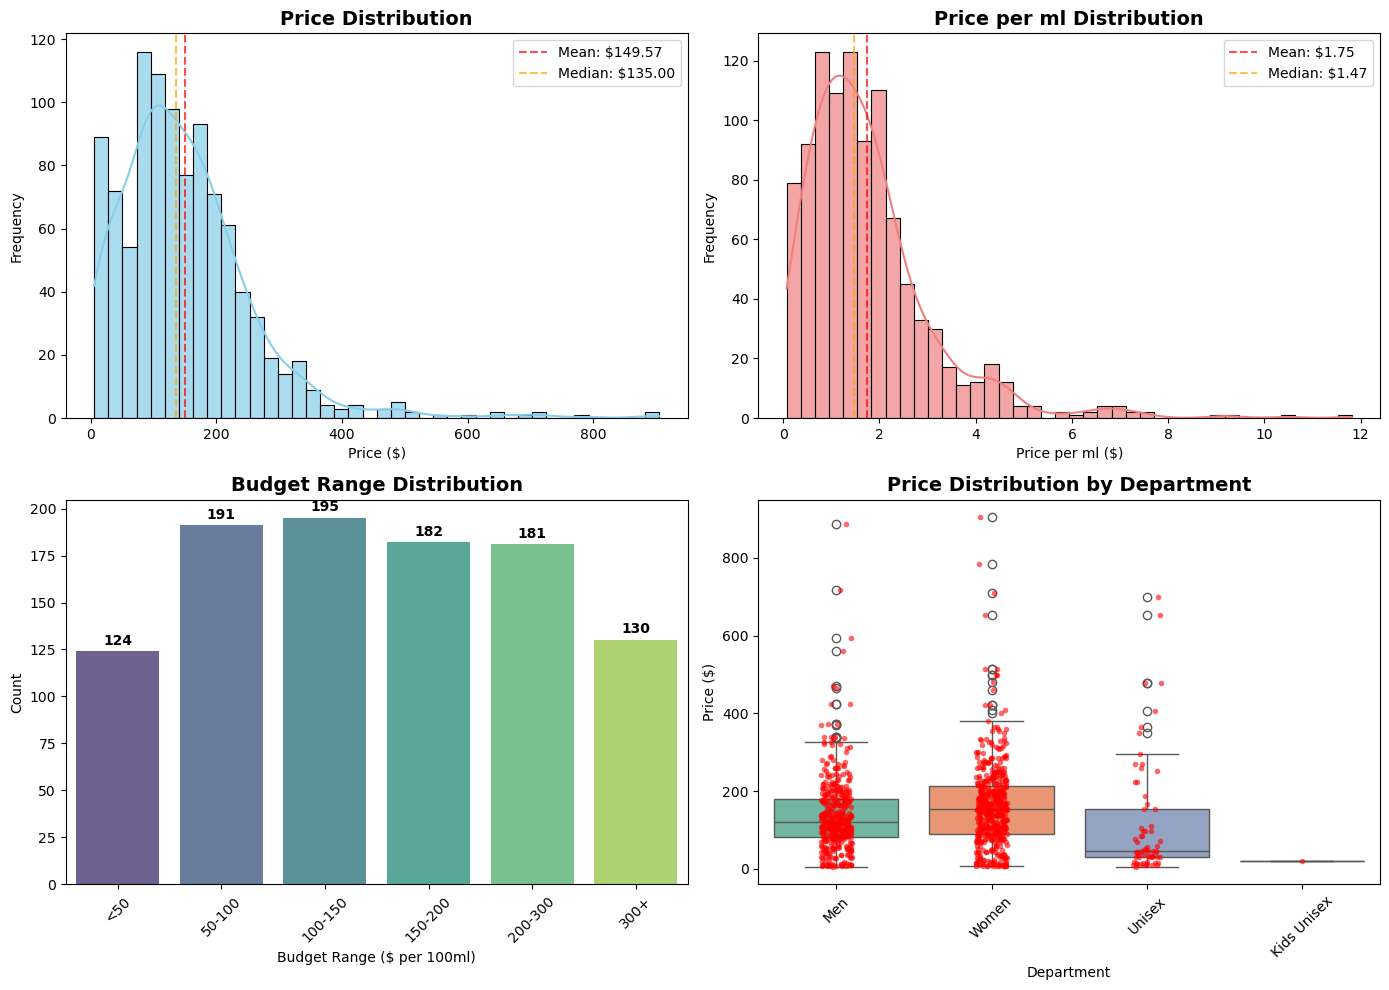

--------------------------------------------------
PRICE ANALYSIS SUMMARY
--------------------------------------------------
Dataset size: 1,003 fragrances

Price Statistics:
Mean price: $149.57
Median price: $135.00
Price range: $5.35 - $904.85
Standard deviation: $108.69

Price per ml Statistics:
Mean price/ml: $1.75
Median price/ml: $1.47
Range price/ml: $0.07 - $11.81

Price by Department:
Kids Unisex: Mean $20.90, Median $20.90 (1 items)
Men: Mean $138.90, Median $119.55 (433 items)
Unisex: Mean $119.86, Median $47.20 (66 items)
Women: Mean $162.92, Median $154.70 (503 items)
--------------------------------------------------


In [163]:
plot_price_distribution(df_analyze, figsize=(14, 10))

# Recommendation System for Chatbot

In [164]:
class FragranceDataProcess:
    #Handles all data loading, cleaning, and feature engineering
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.raw_data = None
        self.processed_data = None
        
    def load_and_clean_data(self):
        """Load and perform initial cleaning of the perfume dataset"""
        self.raw_data = pd.read_csv(self.data_path)
        df = self.raw_data.copy()
        
        # Fix seller ratings
        def fix_rating(r):
            if r > 5:
                if r < 100:
                    r = r/10
                elif r > 100:
                    r = r/100
            return r
        
        df['seller_rating'] = df['seller_rating'].apply(fix_rating)
        
        # Clean department and concentration columns
        df["department"] = df["department"].str.lower().str.replace("kids unisex", "unisex")
        df['concentration'] = df['concentration'].str.lower().str.replace('pdt', 'edt')
        
        # Calculate price per ml
        df['price_per_ml'] = df['new_price'] / df['ml']
        
        return df
    
    def add_scent_features(self, df):
        # Add binary scent features to the dataframe
        df_copy = df.copy()
        
        # Clean scents column
        df_copy['scents'] = df_copy['scents'].str.replace(r'\band\b', ' ', case=False, regex=True)
        df_copy['scents'] = df_copy['scents'].str.replace(',', ' ', case=False, regex=True)
        df_copy['scents'] = df_copy['scents'].str.replace(r'\s+', ' ', case=False, regex=True)
        
        # Create binary features for each scent
        vectorizer = CountVectorizer(tokenizer=str.split, binary=True)
        scents_matrix = vectorizer.fit_transform(df_copy['scents'].fillna(''))
        scents_df = pd.DataFrame(scents_matrix.toarray(), columns=vectorizer.get_feature_names_out())
        
        # Combine with original dataframe
        df_final = pd.concat([df_copy, scents_df], axis=1)
        
        return df_final
    
    def add_gender_features(self, df):
        # Add gender dummy variables
        df_copy = df.copy()
        gender_df = pd.get_dummies(df_copy["department"], dtype=int)
        df_final = pd.concat([df_copy, gender_df], axis=1)
        return df_final
    
    def add_budget_features(self, df):
        # Add budget range categories
        df_copy = df.copy()
        
        # Calculate price per 100ml for mapping
        df_copy['price_per_100ml'] = df_copy['price_per_ml'] * 100
        
        # Define budget mapping function
        def map_budget_range(price_per_100ml):
            if price_per_100ml < 50:
                return 1
            elif 50 <= price_per_100ml < 100:
                return 2
            elif 100 <= price_per_100ml < 150:
                return 3
            elif 150 <= price_per_100ml < 200:
                return 4
            elif 200 <= price_per_100ml < 300:
                return 5
            else:  # 300+
                return 6
        
        # Apply budget range mapping
        df_copy['budget_range'] = df_copy['price_per_100ml'].apply(map_budget_range)
        
        # Labels
        budget_labels = {
            1: '<50', 
            2: '50-100', 
            3: '100-150',
            4: '150-200', 
            5: '200-300', 
            6: '300+'
        }
        df_copy['budget_range_label'] = df_copy['budget_range'].map(budget_labels)
        
        return df_copy
    
    def add_season_features(self, df):
        # Add season concentration mapping
        df_copy = df.copy()
        
        def map_season_concentration(concentration):
            conc = str(concentration).lower().strip()
            
            # Spring/Summer (lighter concentrations)
            if conc in ['edc', 'edt']:
                return 1  
            # Fall/Winter (stronger concentrations)
            elif conc in ['edp', 'oil']:
                return 2
            else:
                return 2  # Default to Fall/Winter
            
        df_copy['season_concentration'] = df_copy['concentration'].apply(map_season_concentration)
        return df_copy
    
    def process_all_features(self):
        # Apply all data processing transformations
        df = self.load_and_clean_data()
        df = self.add_scent_features(df)
        df = self.add_gender_features(df)  
        df = self.add_budget_features(df)
        df = self.add_season_features(df)
        
        self.processed_data = df
        return df


In [165]:
class FragranceQuestionnaire:
    # Handles all user interaction and profile building
    
    def __init__(self):
        self.user_profile = {}
        self.questions = [
            {
                'id': 0, 'question': 'What is your name?', 'attribute': 'name',
                'type': 'text', 'conditions': None
            },
            {
                'id': 1, 'question': 'Which gender perfume are you looking for?',
                'type': 'multi-choice', 'attribute': 'gender',
                'answers': {1: 'Women', 2: 'Men', 3: 'Unisex'}, 'conditions': None  
            },
            {
                'id': 2, 'question': 'Are you shopping for yourself or buying a gift?',
                'type': 'single-choice', 'attribute': 'target',
                'answers': {1: 'Myself', 2: 'Gift'}, 'conditions': None  
            },
            {
                'id': 3, 'question': 'Which personality best describes the recipient?',
                'type': 'single-choice', 'attribute': 'personality',
                'answers': {1: 'Adventurous / Bold', 2: 'Romantic / Elegant', 
                           3: 'Fresh / Energetic', 4: 'Warm / Comforting', 5: 'Exotic / Mysterious'},
                'conditions': {'target': [2]}  
            },
            # Personality-specific questions
            {
                'id': 4, 'question': 'What kind of bold scent would they prefer?',
                'type': 'multi-choice', 'attribute': 'bold-scent',
                'answers': {1: 'Woody (strong, earthy)', 2: 'Spicy (warm, intense)', 3: 'Oriental (rich, exotic)'},
                'conditions': {'personality': [1]}
            },
            {
                'id': 5, 'question': 'Which elegant note fits their style?',
                'type': 'multi-choice', 'attribute': 'elegant-scent',
                'answers': {1: 'Floral and Oriental (classic, feminine)', 2: 'Sweet Aromatic (soft, charming)'},
                'conditions': {'personality': [2]}
            },
            {
                'id': 6, 'question': 'Which fresh vibe suits them best?',
                'type': 'multi-choice', 'attribute': 'fresh-scent',
                'answers': {1: 'Fresh (clean, crisp)', 2: 'Citrus (zesty, bright)', 3: 'Fruity (sweet, lively)'},
                'conditions': {'personality': [3]}
            },
            {
                'id': 7, 'question': 'Which comforting scent would they enjoy?',
                'type': 'multi-choice', 'attribute': 'comforting-scent',
                'answers': {1: 'Vanilla (sweet, cozy)', 2: 'Musk (soft, sensual)', 3: 'Sandalwood (smooth, woody)'},
                'conditions': {'personality': [4]}
            },
            {
                'id': 8, 'question': 'Which mysterious scent appeals to them?',
                'type': 'multi-choice', 'attribute': 'mysterious-scent',
                'answers': {1: 'Woody and Spicy (bold, complex)', 2: 'Arabian (rich, luxurious)'},
                'conditions': {'personality': [5]}
            },
            # Myself flow questions
            {
                'id': 9, 'question': 'Which season do you prefer the perfume for?',
                'type': 'single-choice', 'attribute': 'season',
                'answers': {1: 'Spring / Summer', 2: 'Fall / Winter'},
                'conditions': {'target': [1]}  
            },
            {
                'id': 10, 'question': 'What occasion is the perfume for?',
                'type': 'single-choice', 'attribute': 'occasion',
                'answers': {1: 'Casual', 2: 'Formal', 3: 'Romantic', 4: 'Party', 5: 'Work'},
                'conditions': {'season': [1]} 
            },
            {
                'id': 11, 'question': 'What occasion is the perfume for?',
                'type': 'single-choice', 'attribute': 'occasion',
                'answers': {1: 'Casual', 2: 'Formal', 3: 'Romantic', 4: 'Party', 5: 'Work'},
                'conditions': {'season': [2]} 
            },
            # Scent preference questions for "myself" route
            {
                'id': 12, 'question': 'Which fresh vibe suits you best?',
                'type': 'single-choice', 'attribute': 'fresh-scent-self',
                'answers': {1: 'Fresh (clean, crisp)', 2: 'Citrus (zesty, bright)', 3: 'Fruity (sweet, lively)'},
                'conditions': {'season': [1], 'occasion': [1, 4]}  
            },
            {
                'id': 13, 'question': 'Which elegant note fits your style?',
                'type': 'multi-choice', 'attribute': 'elegant-scent-self',
                'answers': {1: 'Floral and Oriental (classic, feminine)', 2: 'Sweet Aromatic (soft, charming)'},
                'conditions': {'season': [1], 'occasion': [2, 3]}  
            },
            {
                'id': 14, 'question': 'Which clean or aromatic scent do you prefer?',
                'type': 'multi-choice', 'attribute': 'clean-aromatic-scent-self',
                'answers': {1: 'Clean (fresh, crisp)', 2: 'Aromatic (herbal, lively)', 3: 'Woody (warm, classic)'},
                'conditions': {'season': [1, 2], 'occasion': [5]}  
            },
            {
                'id': 15, 'question': 'What kind of bold scent do you prefer?',
                'type': 'multi-choice', 'attribute': 'bold-scent-self',
                'answers': {1: 'Woody (strong, earthy)', 2: 'Spicy (warm, intense)', 3: 'Oriental (rich, exotic)'},
                'conditions': {'season': [2], 'occasion': [1, 4]}  
            },
            {
                'id': 16, 'question': 'Which comforting scent would you enjoy?',
                'type': 'multi-choice', 'attribute': 'comforting-scent-self',
                'answers': {1: 'Vanilla (sweet, cozy)', 2: 'Musk (soft, sensual)', 3: 'Sandalwood (smooth, woody)'},
                'conditions': {'season': [2], 'occasion': [2, 3]}
            },
            # Brand and budget questions
            {
                'id': 17, 'question': 'Please choose your preferred brand category?',
                'type': 'single-choice', 'attribute': 'brand-category',
                'answers': {
                    1: 'Luxury: (Chanel, Dior, Gucci, etc.)',
                    2: 'Mid-Range: (Hugo Boss, Calvin Klein, Marc Jacobs, etc.)',
                    3: 'Designer: (Versace, Michael Kors, Coach, etc.)',
                    4: 'Niche: (Arabian Oud, Rasasi, Ajmal, etc.)',
                    5: 'Affordable: (Avon, Revlon, Elizabeth Arden, etc.)'
                },
                'conditions': None  
            },
            {
                'id': 18, 'question': "What's your budget range (for 100ml size) for the perfume?",
                'type': 'single-choice', 'attribute': 'budget-luxury',
                'answers': {1: '$100 - $200', 2: '$200 - $300', 3: '$300+'},
                'conditions': {'brand-category': [1, 4]}
            },
            {
                'id': 19, 'question': "What's your budget (for 100ml size) for the perfume?",
                'type': 'single-choice', 'attribute': 'budget-midrange', 
                'answers': {1: '$50 - $100', 2: '$100 - $150', 3: '$150+'},
                'conditions': {'brand-category': [2, 3]}
            },
            {
                'id': 20, 'question': "What's your budget range (for 100ml size) for the perfume?",
                'type': 'single-choice', 'attribute': 'budget-affordable',  
                'answers': {1: 'Under $50', 2: '$50 - $75', 3: '$75+'},
                'conditions': {'brand-category': [5]}
            } 
        ]
    
    def check_valid_input(self, user_input_list, valid_range):
        # Check if user input is within valid range
        if not user_input_list:
            print("Invalid choice (empty).")
            return False
        
        for user_input in user_input_list:
            try:
                num = int(user_input)
                if not (1 <= num <= valid_range):
                    print(f"Invalid choice. Please input a number within the valid range.")
                    return False
            except ValueError:
                print(f"Invalid input '{user_input}'. Please input a whole number.")
                return False
        
        return True
    
    def ask_text_question(self, question_id):
        # Handle text input questions
        q = self.questions[question_id]
        print(q['question'])
        
        while True:
            user_input = input("Your name (or 0 to exit): ").strip()
            
            if user_input == '0':
                raise Exception("Program terminated. Thank you for using our Fragrance Recommendation Chatbot.") 
            
            if user_input:
                print(f"Your name: {user_input}")
                self.user_profile[q['attribute']] = user_input
                return True
            else:
                print("Please enter your name or 0 to exit.")
   
    
    def ask_single_choice_question(self, question_id):
        # Handle single choice questions
        q = self.questions[question_id]
        valid_range = len(q['answers'])

        print(q['question'])
        print("Options: ")
        for idx, key in q['answers'].items():
            print(f"{idx}. {key}")

        while True:
            user_input = input(f"Select one option (e.g: 1) (or press 0 to exit): ").strip()
            
            if user_input == '0':
                raise Exception("Program terminated. Thank you for using our Fragrance Recommendation Chatbot.") 
            
            print(f"You input: {user_input}")

            user_input_list = [x.strip() for x in re.split(r'[,\s;]+', user_input) if x.strip()]
                        
            if len(user_input_list) != 1:
                print("Invalid choice. Please select ONE option")
                continue
                
            if self.check_valid_input(user_input_list, valid_range):
                break
        
        # Update boolean flags
        result = {}
        for answer_key, answer_value in q['answers'].items():
            result[answer_value] = (str(answer_key) == user_input_list[0])

        self.user_profile[q['attribute']] = result
        return int(user_input_list[0])
    
    def ask_multi_choice_question(self, question_id):
        q = self.questions[question_id]
        valid_range = len(q['answers'])
        
        print(q['question'])
        print("Options: ")
        for idx, key in q['answers'].items():
            print(f"{idx}. {key}")
                    
        while True:
            user_input = input(
                f"Input one or more numbers from 1 to {valid_range} "
                "(e.g: 1, 2) (or press 0 to exit): "
            ).strip()
            
            print(f"You input: {user_input}")
            
            if user_input == '0':
                raise Exception("Program terminated. Thank you for using our Fragrance Recommendation Chatbot.") 
             
            user_input_list = [x for x in re.split(r'[,\s;]+', user_input) if x]

            if self.check_valid_input(user_input_list, valid_range):
                break
        
        # Update boolean flags
        result = {}
        for answer_key, answer_value in q['answers'].items():
            result[answer_value] = str(answer_key) in user_input_list
                    
        self.user_profile[q['attribute']] = result
        return user_input_list
    
    def ask_question(self, question_id):
        # Route to appropriate question handler based on type
        q = self.questions[question_id]
        
        if q['type'] == 'text':
            return self.ask_text_question(question_id)
        elif q['type'] == 'single-choice':
            return self.ask_single_choice_question(question_id)
        elif q['type'] == 'multi-choice':
            return self.ask_multi_choice_question(question_id)
    
    def run_questionnaire(self):
        # Run the complete questionnaire flow
        try:
            print("Welcome to the Fragrance Recommendation System!")
            print("(Enter 0 at any time to exit the chatbot)")
            
            # Q0: Name
            self.ask_question(0)
            
            # Q1: Gender
            self.ask_question(1)
            
            # Q2: Target
            target_choice = self.ask_question(2)
            
            # Branch based on target choice
            if target_choice == 1:  # Myself flow
                print("\n-------- Shopping for yourself ---------\n")   
                
                season_choice = self.ask_question(9)

                if season_choice == 1:  # Spring/Summer
                    occasion_choice = self.ask_question(10)
                else:  # Fall/Winter
                    occasion_choice = self.ask_question(11)
                    
                # Additional scent questions based on season and occasion
                if season_choice == 1:  # Spring/Summer
                    if occasion_choice in [1, 4]:  # Casual or Party
                        self.ask_question(12)
                    elif occasion_choice in [2, 3]:  # Formal or Romantic
                        self.ask_question(13)
                    elif occasion_choice == 5:  # Work
                        self.ask_question(14)
                        
                else:  # Fall/Winter
                    if occasion_choice in [1, 4]:  # Casual or Party
                        self.ask_question(15)
                    elif occasion_choice in [2, 3]:  # Formal or Romantic
                        self.ask_question(16)
                    elif occasion_choice == 5:  # Work
                        self.ask_question(14)
                        
            elif target_choice == 2:  # Gift flow
                print("\n-------- Shopping for a gift ---------\n")   
                
                personality_choice = self.ask_question(3)
                
                # Personality-specific scent questions
                if personality_choice == 1:  # Adventurous/Bold
                    self.ask_question(4)
                elif personality_choice == 2:  # Romantic/Elegant
                    self.ask_question(5)
                elif personality_choice == 3:  # Fresh/Energetic
                    self.ask_question(6)
                elif personality_choice == 4:  # Warm/Comforting
                    self.ask_question(7)
                elif personality_choice == 5:  # Exotic/Mysterious
                    self.ask_question(8)
            
            # Brand and budget questions for both routes
            print("\n-------- Brand and Budget Information --------")
            
            brand_choice = self.ask_question(17)
            
            # Budget question based on brand category
            if brand_choice in [1, 4]:  # Luxury or Niche
                self.ask_question(18)
            elif brand_choice in [2, 3]:  # Mid-Range or Designer
                self.ask_question(19)
            elif brand_choice == 5:  # Affordable
                self.ask_question(20)
                
            return self.user_profile
            
        except Exception as e:
            print(e)
            return None


In [166]:
class FragranceRecommendationEngine:    
    def __init__(self, processed_data):
        self.processed_data = processed_data
        self.original_cols = ['Unnamed: 0', 'brand', 'name', 'old_price', 'new_price', 'ml', 
                             'concentration', 'department', 'scents', 'base_note', 'middle_note', 
                             'item_rating', 'seller', 'seller_rating', 'num_seller_ratings', 
                             'price_per_ml', 'price_per_100ml', 'budget_range_label']
        self.feature_cols = [col for col in processed_data.columns if col not in self.original_cols]
    
    def transform_user_profile(self, user_profile):
        # Transform user profile to feature vector for similarity calculation
        
        # Initialize user vector
        user_vector = {col: 0 for col in self.feature_cols}
        activated_features = []
        
        # 1. GENDER
        gender_data = user_profile.get('gender', {})
        for gender_option, is_selected in gender_data.items():
            if is_selected and gender_option.lower() in user_vector:
                user_vector[gender_option.lower()] = 1
                activated_features.append(f"Gender: {gender_option}")
        
        # 2. SEASON
        season_data = user_profile.get('season', {})
        if 'season_concentration' in user_vector:
            spring_summer_selected = season_data.get('Spring / Summer', False)
            fall_winter_selected = season_data.get('Fall / Winter', False)
            
            if spring_summer_selected:
                user_vector['season_concentration'] = 1
                activated_features.append("Season: Spring/Summer")
            elif fall_winter_selected:
                user_vector['season_concentration'] = 2
                activated_features.append("Season: Fall/Winter")
        
        # 3. BUDGET
   
        # Check different budget categories
        
        for budget_attr in ['budget-luxury', 'budget-midrange', 'budget-affordable']:
            budget_data = user_profile.get(budget_attr, {})
            
            for budget_option, is_selected in budget_data.items():
                if is_selected:
                    if '$300+' in budget_option:
                        budget_value = 6
                        activated_features.append(f"Budget: {budget_option} (High Luxury)")
                    elif '$200 - $300' in budget_option:
                        budget_value = 5
                        activated_features.append(f"Budget: {budget_option} (Luxury)")
                    elif '$100 - $200' in budget_option:
                        budget_value = 4
                        activated_features.append(f"Budget: {budget_option} (Premium)")
                    elif '$150+' in budget_option:
                        budget_value = 4
                        activated_features.append(f"Budget: {budget_option} (Premium)")
                    elif '$100 - $150' in budget_option:
                        budget_value = 3
                        activated_features.append(f"Budget: {budget_option} (Mid-High)")
                    elif '$75+' in budget_option:
                        budget_value = 3
                        activated_features.append(f"Budget: {budget_option} (Mid-High)")
                    elif '$50 - $100' in budget_option:
                        budget_value = 2
                        activated_features.append(f"Budget: {budget_option} (Mid-Range)")
                    elif '$50 - $75' in budget_option:
                        budget_value = 2
                        activated_features.append(f"Budget: {budget_option} (Mid-Range)")
                    elif 'Under $50' in budget_option:
                        budget_value = 1
                        activated_features.append(f"Budget: {budget_option} (Affordable)")
            
        user_vector['budget_range'] = budget_value
        
        # 4. SCENT PREFERENCES
        scent_attribute_mappings = {
            'fresh-scent-self': {
                'Fresh (clean, crisp)': ['fresh', 'clean'],
                'Citrus (zesty, bright)': ['citrus'],
                'Fruity (sweet, lively)': ['fruity', 'sweet']
            },
            'fresh-scent': {
                'Fresh (clean, crisp)': ['fresh', 'clean'],
                'Citrus (zesty, bright)': ['citrus'],
                'Fruity (sweet, lively)': ['fruity', 'sweet']
            },
            'elegant-scent-self': {
                'Floral and Oriental (classic, feminine)': ['floral', 'oriental', 'rose', 'jasmine'],
                'Sweet Aromatic (soft, charming)': ['sweet', 'aromatic', 'vanilla']
            },
            'elegant-scent': {
                'Floral and Oriental (classic, feminine)': ['floral', 'oriental', 'rose', 'jasmine'],
                'Sweet Aromatic (soft, charming)': ['sweet', 'aromatic', 'vanilla']
            },
            'bold-scent-self': {
                'Woody (strong, earthy)': ['woody', 'sandalwood'],
                'Spicy (warm, intense)': ['spicy'],
                'Oriental (rich, exotic)': ['oriental']
            },
            'bold-scent': {
                'Woody (strong, earthy)': ['woody', 'sandalwood'],
                'Spicy (warm, intense)': ['spicy'],
                'Oriental (rich, exotic)': ['oriental']
            },
            'comforting-scent-self': {
                'Vanilla (sweet, cozy)': ['vanilla', 'sweet'],
                'Musk (soft, sensual)': ['musk', 'musky'],
                'Sandalwood (smooth, woody)': ['sandalwood', 'woody']
            },
            'comforting-scent': {
                'Vanilla (sweet, cozy)': ['vanilla', 'sweet'],
                'Musk (soft, sensual)': ['musk', 'musky'],
                'Sandalwood (smooth, woody)': ['sandalwood', 'woody']
            },
            'mysterious-scent': {
                'Woody and Spicy (bold, complex)': ['woody', 'spicy'],
                'Arabian (rich, luxurious)': ['arabian', 'oriental']
            },
            'clean-aromatic-scent-self': {
                'Clean (fresh, crisp)': ['clean', 'fresh'],
                'Aromatic (herbal, lively)': ['aromatic'],
                'Woody (warm, classic)': ['woody', 'sandalwood']
            }
        }
        
        # Process all scent-related attributes
        for scent_attr, scent_mappings in scent_attribute_mappings.items():
            scent_data = user_profile.get(scent_attr, {})
            
            for scent_option, is_selected in scent_data.items():
                if is_selected and scent_option in scent_mappings:
                    keywords = scent_mappings[scent_option]
                    
                    for keyword in keywords:
                        if keyword in user_vector:
                            user_vector[keyword] = 1
                            activated_features.append(f"Scent: {keyword}")
        
        print(f"Activated features: {activated_features}")
        return user_vector
    
    def get_recommendations(self, user_profile, top_n=5):
        # Generate perfume recommendations based on user profile
        
        # Transform user profile
        user_vector_dict = self.transform_user_profile(user_profile)
        
        # Create vectors for similarity calculation
        user_vector = [user_vector_dict[col] for col in self.feature_cols]
        df_feature_matrix = self.processed_data[self.feature_cols].fillna(0)
        
        print(f"\nUser vector active features: {sum(user_vector)}")
        print(f"Feature matrix shape: {df_feature_matrix.shape}")
        
        # Calculate cosine similarity
        similarities = cosine_similarity([user_vector], df_feature_matrix)[0]
        
        # Get top recommendations
        df_results = self.processed_data.copy()
        df_results['similarity_score'] = similarities
        
        df_results = df_results.loc[df_results.groupby(['brand', 'name'])['similarity_score'].idxmax()]
        
        recommendations = df_results.nlargest(top_n, 'similarity_score')
        
        return recommendations[['brand', 'name', 'department', 'scents', 'middle_note', 'base_note', 
                                'concentration', 'ml', 'new_price', 'budget_range_label', 
                                'season_concentration', 'similarity_score', 'price_per_100ml']]    
        
    def display_recommendations(self, recommendations):
        # Display recommendations
        print("\n" + "-"*60)
        print("PERFUME RECOMMENDATIONS FOR YOU")
        print("-"*60)
        
        season_map = {1: "Spring/Summer", 2: "Fall/Winter"}
        
        for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
            season = season_map.get(row['season_concentration'], "N/A")
            
            print(f"\n{i}. {row['brand']} - {row['name']} - {row['ml']}ml")
            print(f"Category: {row['department'].title()}")
            print(f"Top Notes: {row['scents']}")
            print(f"Middle Notes: {row['middle_note'] if pd.notna(row['middle_note']) else 'Not specified'}")
            print(f"Base Notes: {row['base_note'] if pd.notna(row['base_note']) else 'Not specified'}")
            print(f"Price: ${row['new_price']:.2f}")
            print(f"Price_per_100ml: {row['price_per_100ml']:.2f} | Season Type: {season}")
            print(f"Match Score: {row['similarity_score']:.3f}")
            print("-" * 50)
            

In [167]:
def run_fragrance_chatbot(data_path, top_n=5):
    # 1. Load and preprocess data 
    processing = FragranceDataProcess(data_path)
    processed_data = processing.process_all_features()
    
    while True:  # Main loop for running the chatbot multiple times
        try:
            # 2. Run questionnaire
            questionnaire = FragranceQuestionnaire()
            user_profile = questionnaire.run_questionnaire()
            
            # Check if user_profile is None
            if user_profile is None:
                break
                
            # 3. Generate recommendations
            recommender = FragranceRecommendationEngine(processed_data)
            recommendations = recommender.get_recommendations(user_profile, top_n=top_n)
            
            # 4. Display recommendations
            recommender.display_recommendations(recommendations)
            
            # 5. Ask if user wants to try again
            print("\n" + "-"*60)
            while True:
                restart_choice = input("Do you want us to make your custom recommendation again? (y/n): ").strip().lower()
                
                if restart_choice in ['y', 'yes']:
                    print("\n" + "-"*60)
                    print("Let's start fresh with new recommendations!")
                    print("-"*60 + "\n")
                    break  # Break inner loop to restart questionnaire
                elif restart_choice in ['n', 'no']:
                    print("\nThank you for using our Fragrance Recommendation Chatbot!")
                    print("Hope you find your perfect fragrance!")
                    return recommendations  # Exit the function
                else:
                    print("Please enter 'y' for yes or 'n' for no.")
                    
        except Exception as e:
            print(f"\nAn error occurred: {e}")
            print("Thank you for using our Fragrance Recommendation Chatbot!")
            break
    
    return None

In [168]:
if __name__ == "__main__":
    data_path = "../chatbot__fragrance_recommendation/data/noon_perfumes_dataset.csv"
    recs = run_fragrance_chatbot(data_path, top_n=5)

Welcome to the Fragrance Recommendation System!
(Enter 0 at any time to exit the chatbot)
What is your name?
Your name: sophia
Which gender perfume are you looking for?
Options: 
1. Women
2. Men
3. Unisex
You input: 1
Are you shopping for yourself or buying a gift?
Options: 
1. Myself
2. Gift
You input: 1

-------- Shopping for yourself ---------

Which season do you prefer the perfume for?
Options: 
1. Spring / Summer
2. Fall / Winter
You input: 3
Invalid choice. Please input a number within the valid range.
You input: 1
What occasion is the perfume for?
Options: 
1. Casual
2. Formal
3. Romantic
4. Party
5. Work
You input: 1
Which fresh vibe suits you best?
Options: 
1. Fresh (clean, crisp)
2. Citrus (zesty, bright)
3. Fruity (sweet, lively)
You input: 1

-------- Brand and Budget Information --------
Please choose your preferred brand category?
Options: 
1. Luxury: (Chanel, Dior, Gucci, etc.)
2. Mid-Range: (Hugo Boss, Calvin Klein, Marc Jacobs, etc.)
3. Designer: (Versace, Michael Ko